In [1]:
import tensorflow as tf
import pandas as pd
import cv2
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn
from keras.utils import plot_model
import torch, gc
from tensorflow.keras import mixed_precision
import time

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
mixed_precision.set_global_policy('mixed_float16')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [4]:
categories = ["Punch",  "Rafting", "Surfing", "TableTennisShot", "TennisSwing"]
train_files = ['trainlist01.txt', 'trainlist02.txt', 'trainlist03.txt']
test_files = ['testlist01.txt', 'testlist02.txt', 'testlist03.txt']

In [5]:
def plot_confusion_matrix(y_real, y_pred):
    plt.figure(figsize=(8, 8))
    y_pred = np.argmax(y_pred, axis=1)
    y_real = np.argmax(y_real, axis=1)
    cm = confusion_matrix(y_real, y_pred)
    ax = plt.subplot()
    sn.heatmap(cm, annot=True, fmt="g", ax=ax)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(categories)
    ax.yaxis.set_ticklabels(categories)
    plt.show()

In [6]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [7]:
def print_result(y_real, y_pred, model_name):
    y_pred = np.argmax(y_pred, axis=1)
    y_real = np.argmax(y_real, axis=1)

    acc = accuracy_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred, average="macro")
    precision = precision_score(y_real, y_pred, average="macro")
    recall = recall_score(y_real, y_pred, average="macro")

    print(model_name)
    print("Accuracy is ", acc)
    print("F1 Score is ", f1)
    print("Precision is ", precision)
    print("Recall is ", recall)

    return acc, f1, precision, recall

In [8]:
def get_video_and_label(filenames, categories):
    videos = []
    labels = []
    num_frames = []
    for fname in filenames:
        with open('ucfTrainTestlist/'+fname) as infile:
            for line in infile:
                temp = line.strip().split(" ")
                category = temp[0].split("/")[0]

                if (category in categories):
                    videos.append(temp[0])
                    labels.append(category)
                    video_reader = cv2.VideoCapture("UCF-101/"+temp[0])
                    num_frames.append(int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)))
                    video_reader.release()
    return pd.DataFrame({"filename": videos, "num_frames": num_frames, "label": labels})


In [9]:
train = get_video_and_label(train_files, categories)
test = get_video_and_label(test_files, categories)

In [10]:
train.to_csv("train.csv", encoding='utf-8', index=False)
test.to_csv("test.csv", encoding='utf-8', index=False)

# Kategori Sayıları

In [10]:
train['label'].value_counts()

TennisSwing        356
Punch              348
TableTennisShot    308
Surfing            268
Rafting            238
Name: label, dtype: int64

In [11]:
test['label'].value_counts()

TennisSwing        142
Punch              132
TableTennisShot    112
Surfing            110
Rafting             95
Name: label, dtype: int64

# Ortalama frame sayıları

In [12]:
for category in categories:
    print(category + " : " + str(round(train[train["label"] == category].num_frames.mean())))


Punch : 273
Rafting : 186
Surfing : 198
TableTennisShot : 172
TennisSwing : 161


In [13]:
for category in categories:
    print(category + " : " + str(round(test[test["label"] == category].num_frames.mean())))

Punch : 266
Rafting : 202
Surfing : 208
TableTennisShot : 148
TennisSwing : 154


In [14]:
def feature_extraction(video_path, width, height, num_frames):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip = max(int(frame_count/num_frames), 1)

    for i in range(num_frames):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip)
        ret, frame = video_reader.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255
        frames_list.append(frame)

    video_reader.release()
    return frames_list

In [15]:
def load_video(df, width, height, num_frames):
    frame_list = []
    for index, row in df.iterrows():
        frame_list.append(feature_extraction("UCF-101/"+row["filename"], width, height, num_frames))

    return np.array(frame_list, dtype='float16')

In [16]:
def build_cnn_model(frame, activation, is_dropout):
    model = Sequential()
    model.add(Conv3D(32, (3, 3, 3), activation=activation, input_shape=(frame, 56, 56, 3)))
    model.add(Conv3D(32, (3, 3, 3), activation=activation))
    model.add(MaxPooling3D((1, 2, 2)))
    model.add(Conv3D(32, (3, 3, 3), activation=activation))
    model.add(Conv3D(32, (2, 2, 2), activation=activation))
    model.add(MaxPooling3D((1, 2, 2)))

    if (is_dropout):
        model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    if (is_dropout):
        model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [17]:
def build_lstm_model(frame, activation, is_dropout):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation=activation), input_shape=(frame, 56, 56, 3)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation=activation)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation=activation)))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation=activation)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    if (is_dropout):
        model.add(TimeDistributed(Dropout(0.5)))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [18]:
frame_list = [12,24,36,48]
activation_list = ["relu", "elu", "sigmoid", "tanh"]
dropout = [True, False]
results = {}

In [ ]:
for frame in frame_list:
    X_train = load_video(train, 56, 56, frame)
    X_test = load_video(test, 56, 56, frame)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    y_train = onehot_encoder.fit_transform(
        train.label.to_numpy().reshape(-1, 1))
    y_test = onehot_encoder.fit_transform(test.label.to_numpy().reshape(-1, 1))

    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)
    for activation in activation_list:
        for is_dropout in dropout:
            gc.collect()
            torch.cuda.empty_cache()
            cnn_model = build_cnn_model(
                frame, activation, is_dropout)
            cnn_model_name = "cnn_"+str(frame)+"_frame_"+str(
                activation)+"_activation_"+str(is_dropout)+"_dropout"

            cnn_model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=16)
            y_predicted = cnn_model.predict(X_validation)
            results[cnn_model_name] = print_result(
                y_validation, y_predicted, cnn_model_name)

            gc.collect()
            torch.cuda.empty_cache()
            lstm_model = build_lstm_model(
                frame, activation, is_dropout)
            lstm_model_name = "lstm_"+str(frame)+"_frame_"+str(
                activation)+"_activation_"+str(is_dropout)+"_dropout"

            lstm_model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=16)
            y_predicted = lstm_model.predict(X_validation)
            results[lstm_model_name] = print_result(
                y_validation, y_predicted, lstm_model_name)

# En iyi CNN Modeli
### 24 Frame, ReLU, Dropout yok

In [19]:
X_train_24 = load_video(train, 56, 56, 24)
X_test_24 = load_video(test, 56, 56, 24)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_24 = onehot_encoder.fit_transform(train.label.to_numpy().reshape(-1, 1))
y_test_24 = onehot_encoder.fit_transform(test.label.to_numpy().reshape(-1, 1))

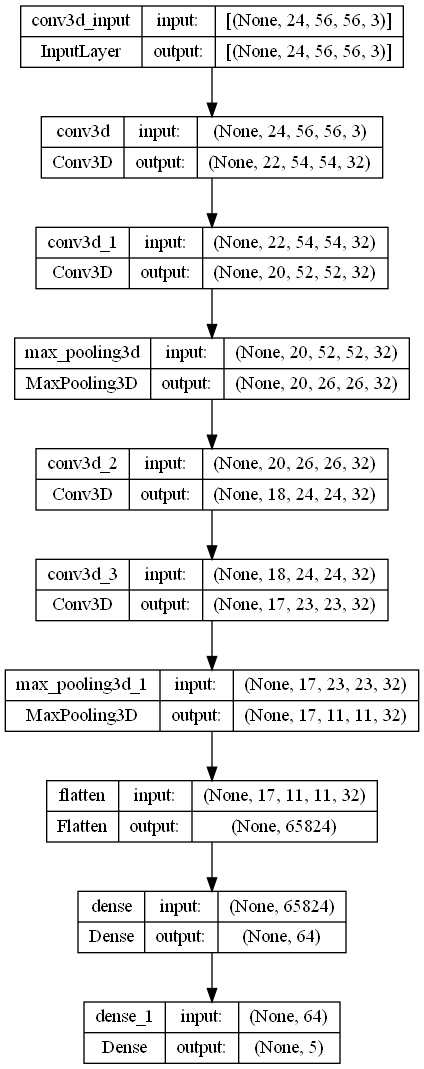

In [20]:
gc.collect()
torch.cuda.empty_cache()
best_cnn_model = build_cnn_model(frame=24, activation="relu", is_dropout=False)
plot_model(best_cnn_model, to_file='cnn_model.png', show_shapes=True)

In [21]:
cnn_model_name = "cnn_24_frame_relu_activation_False_dropout"
folder_name = "weights/" + cnn_model_name + "/"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
checkpoint_name = folder_name+"Weights-{epoch:03d}--{accuracy:.5f}.hdf5"
checkpoint = ModelCheckpoint(
    checkpoint_name, monitor="val_loss", save_best_only=False, verbose=0)
es = EarlyStopping(monitor='val_loss',
                   min_delta=1e-2,
                   patience=2,
                   verbose=0, mode='auto')

start_time = time.time()
history_cnn = best_cnn_model.fit(X_train_24, y_train_24, epochs=100,
                                 validation_split=0.2, batch_size=16, callbacks=[checkpoint, es])
print("--- %s seconds ---" % (time.time() - start_time))
y_predicted_cnn = best_cnn_model.predict(X_test_24)
results_cnn = print_result(y_test_24, y_predicted_cnn, cnn_model_name)


Epoch 1/100
76/76 [==============================] - 31s 316ms/step - loss: 1.1688 - accuracy: 0.5305 - val_loss: 0.6514 - val_accuracy: 0.7566
Epoch 2/100
76/76 [==============================] - 22s 288ms/step - loss: 0.5315 - accuracy: 0.8278 - val_loss: 0.3543 - val_accuracy: 0.8980
Epoch 3/100
76/76 [==============================] - 22s 287ms/step - loss: 0.2626 - accuracy: 0.9119 - val_loss: 0.2491 - val_accuracy: 0.9474
Epoch 4/100
76/76 [==============================] - 22s 288ms/step - loss: 0.1690 - accuracy: 0.9448 - val_loss: 0.0532 - val_accuracy: 0.9901
Epoch 5/100
76/76 [==============================] - 22s 291ms/step - loss: 0.0530 - accuracy: 0.9868 - val_loss: 0.0205 - val_accuracy: 0.9967
Epoch 6/100
76/76 [==============================] - 22s 289ms/step - loss: 0.0735 - accuracy: 0.9778 - val_loss: 0.0314 - val_accuracy: 0.9934
Epoch 7/100
76/76 [==============================] - 22s 291ms/step - loss: 0.0401 - accuracy: 0.9885 - val_loss: 0.0060 - val_accuracy:

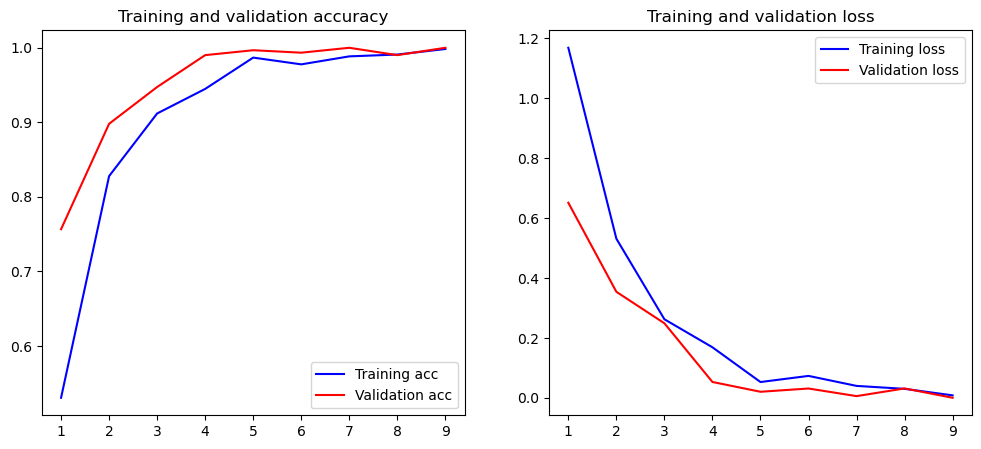

In [22]:
plot_history(history_cnn)

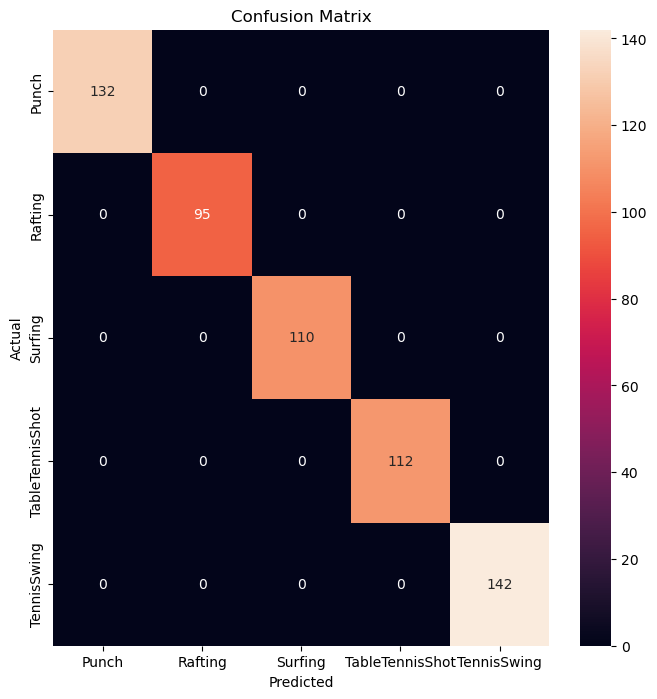

In [23]:
plot_confusion_matrix(y_test_24, y_predicted_cnn)

# En iyi LSTM Modeli
### 12 Frame, Tanh, Dropout var

In [25]:
X_train_12 = load_video(train, 56, 56, 12)
X_test_12 = load_video(test, 56, 56, 12)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_12 = onehot_encoder.fit_transform(train.label.to_numpy().reshape(-1, 1))
y_test_12 = onehot_encoder.fit_transform(test.label.to_numpy().reshape(-1, 1))

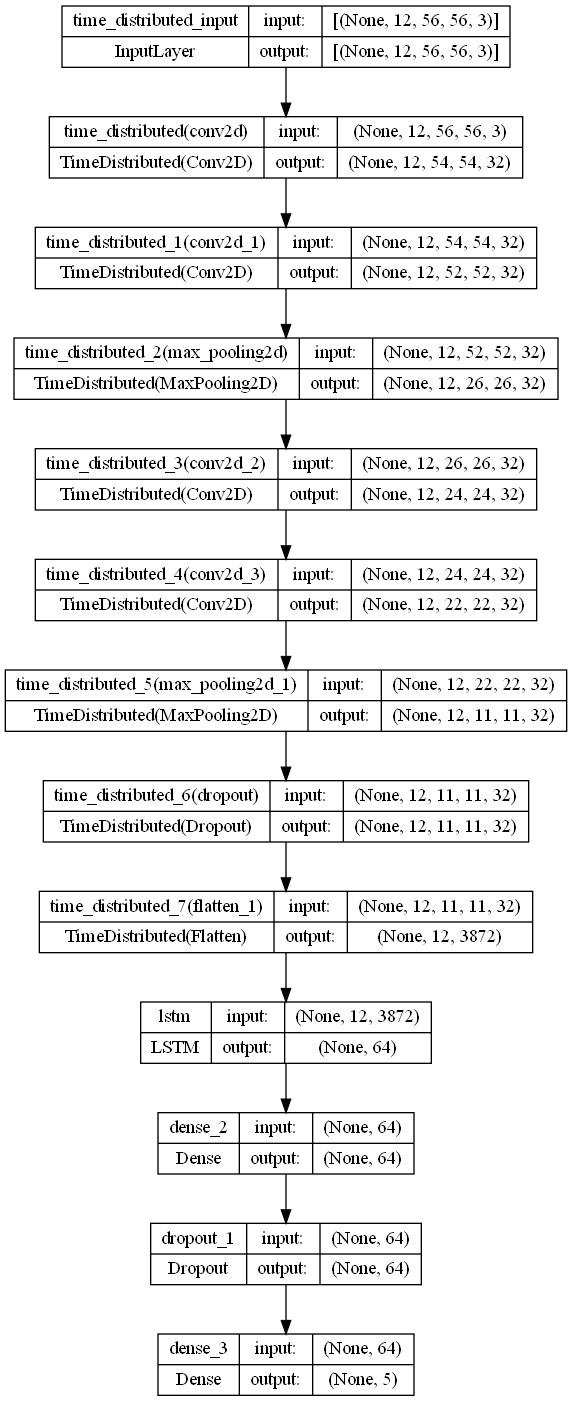

In [26]:
gc.collect()
torch.cuda.empty_cache()
best_lstm_model = build_lstm_model(frame=12, activation="tanh", is_dropout=True)
plot_model(best_lstm_model, to_file='lstm_model.png', show_shapes=True)

In [27]:
lstm_model_name = "lstm_12_frame_tanh_activation_True_dropout"
folder_name = "weights/" + lstm_model_name + "/"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
checkpoint_name = folder_name+"Weights-{epoch:03d}--{accuracy:.5f}.hdf5"
checkpoint = ModelCheckpoint(
    checkpoint_name, monitor="val_loss", save_best_only=False, verbose=0)
es = EarlyStopping(monitor='val_loss',
                   min_delta=1e-2,
                   patience=2,
                   verbose=0, mode='auto')
start_time = time.time()
history_lstm = best_lstm_model.fit(
    X_train_12, y_train_12, epochs=100, validation_split=0.2, batch_size=16, callbacks=[checkpoint, es])
print("--- %s seconds ---" % (time.time() - start_time))
y_predicted_lstm = best_lstm_model.predict(X_test_12)
results_lstm = print_result(y_test_12, y_predicted_lstm, lstm_model_name)


Epoch 1/100
76/76 [==============================] - 15s 138ms/step - loss: 1.1214 - accuracy: 0.5568 - val_loss: 0.7354 - val_accuracy: 0.7467
Epoch 2/100
76/76 [==============================] - 9s 116ms/step - loss: 0.5532 - accuracy: 0.8163 - val_loss: 0.5863 - val_accuracy: 0.8355
Epoch 3/100
76/76 [==============================] - 9s 116ms/step - loss: 0.3498 - accuracy: 0.8871 - val_loss: 0.1816 - val_accuracy: 0.9572
Epoch 4/100
76/76 [==============================] - 9s 115ms/step - loss: 0.1939 - accuracy: 0.9440 - val_loss: 0.0835 - val_accuracy: 0.9868
Epoch 5/100
76/76 [==============================] - 11s 141ms/step - loss: 0.0942 - accuracy: 0.9835 - val_loss: 0.0463 - val_accuracy: 0.9967
Epoch 6/100
76/76 [==============================] - 9s 116ms/step - loss: 0.0608 - accuracy: 0.9868 - val_loss: 0.0514 - val_accuracy: 0.9934
Epoch 7/100
76/76 [==============================] - 9s 117ms/step - loss: 0.0634 - accuracy: 0.9843 - val_loss: 0.0283 - val_accuracy: 0.99

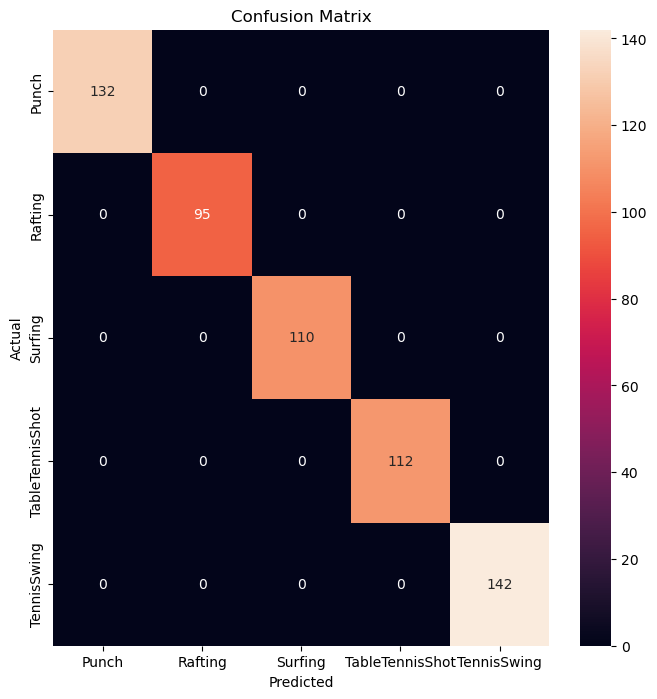

In [31]:
plot_confusion_matrix(y_test_12, y_predicted_lstm)

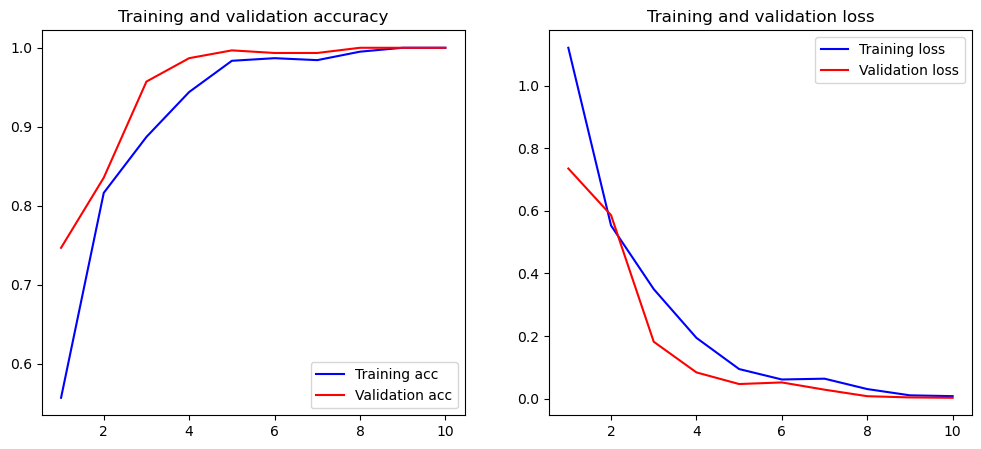

In [28]:
plot_history(history_lstm)

1/1 [==============================] - 0s 41ms/step


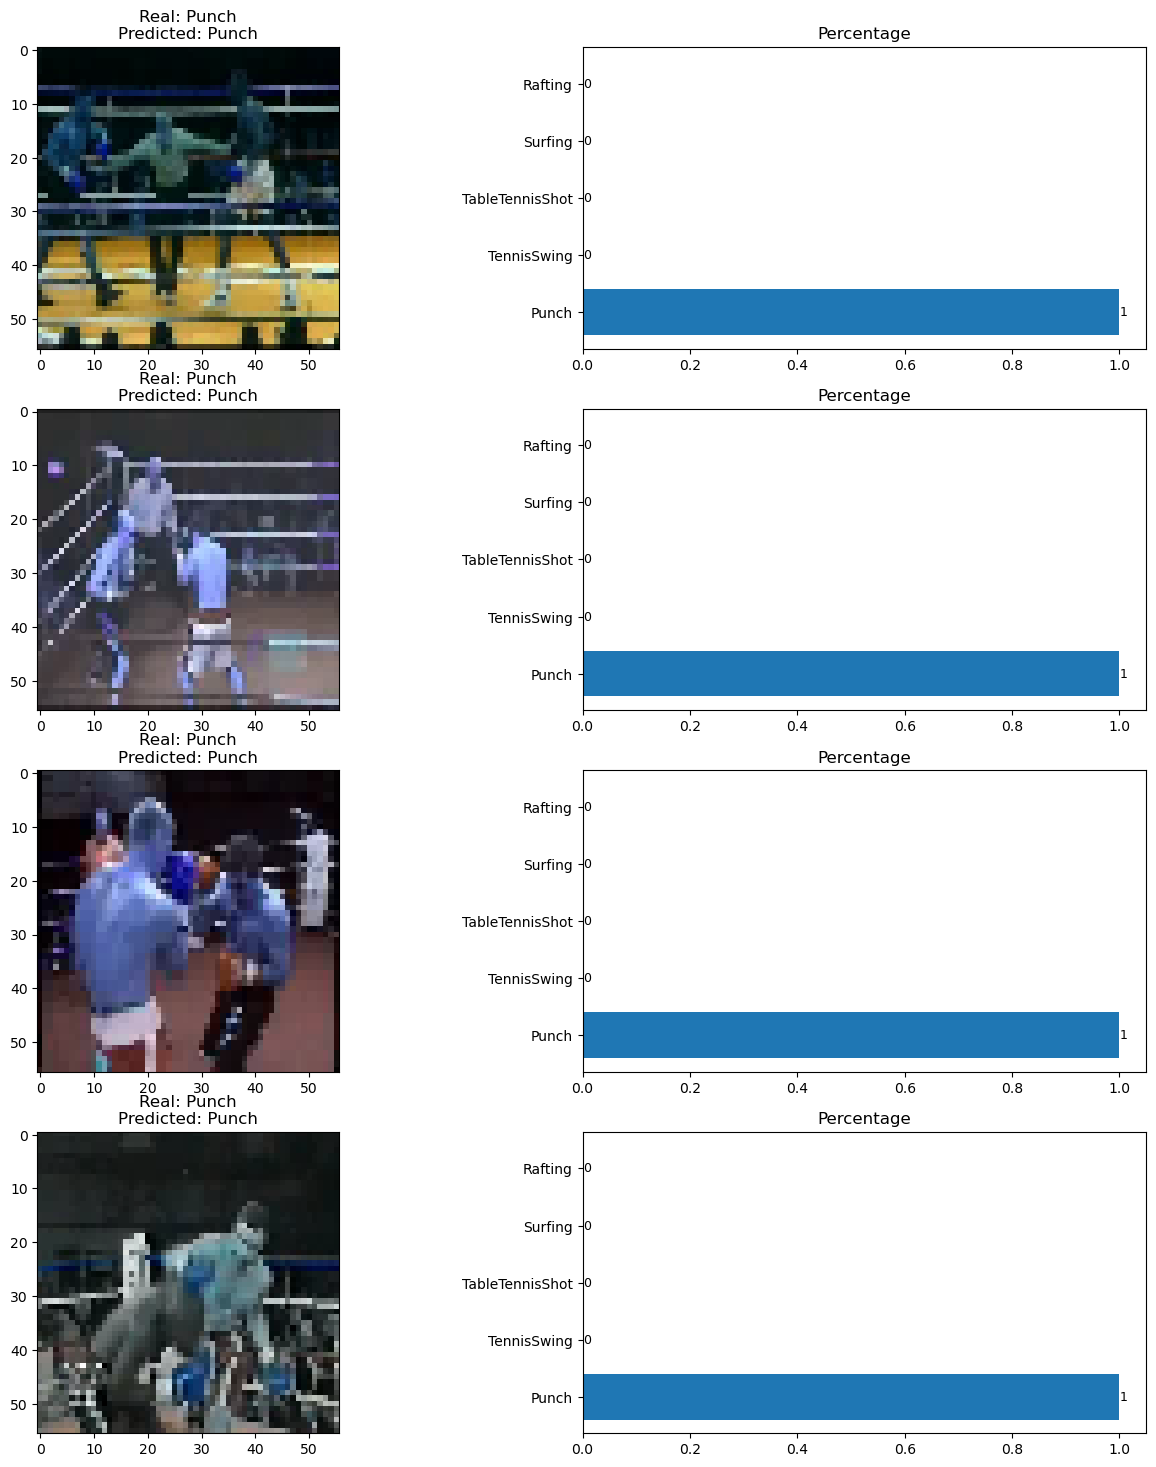

1/1 [==============================] - 0s 53ms/step


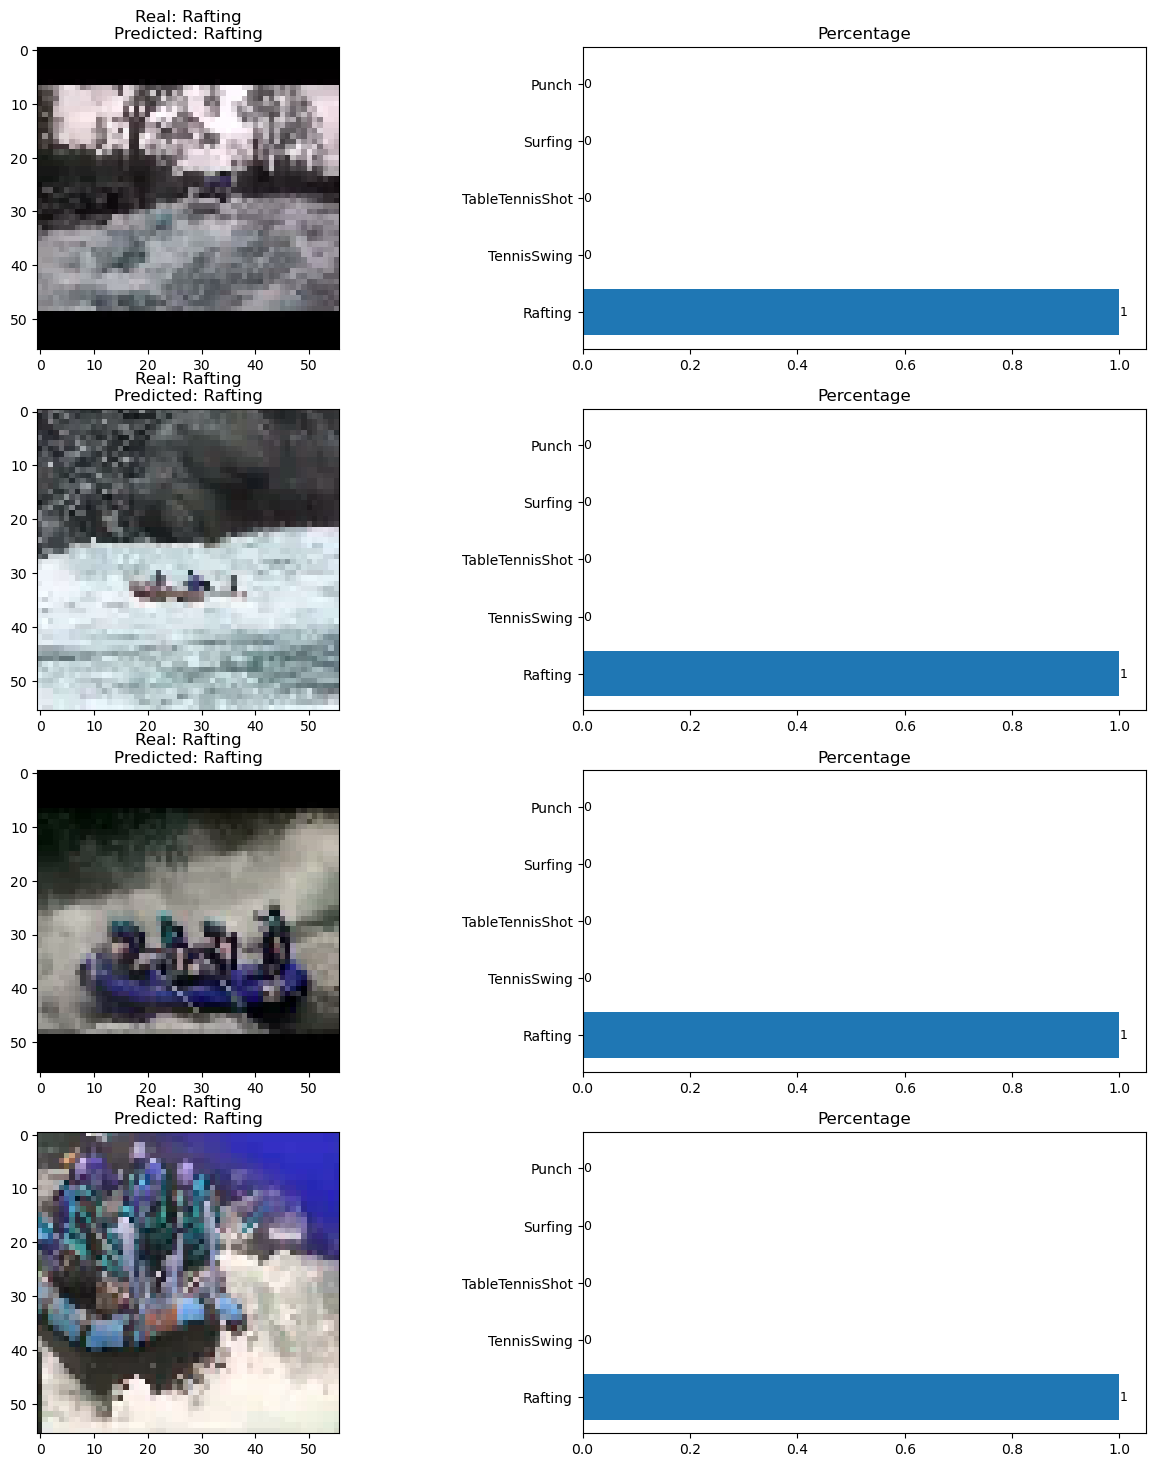

1/1 [==============================] - 0s 41ms/step


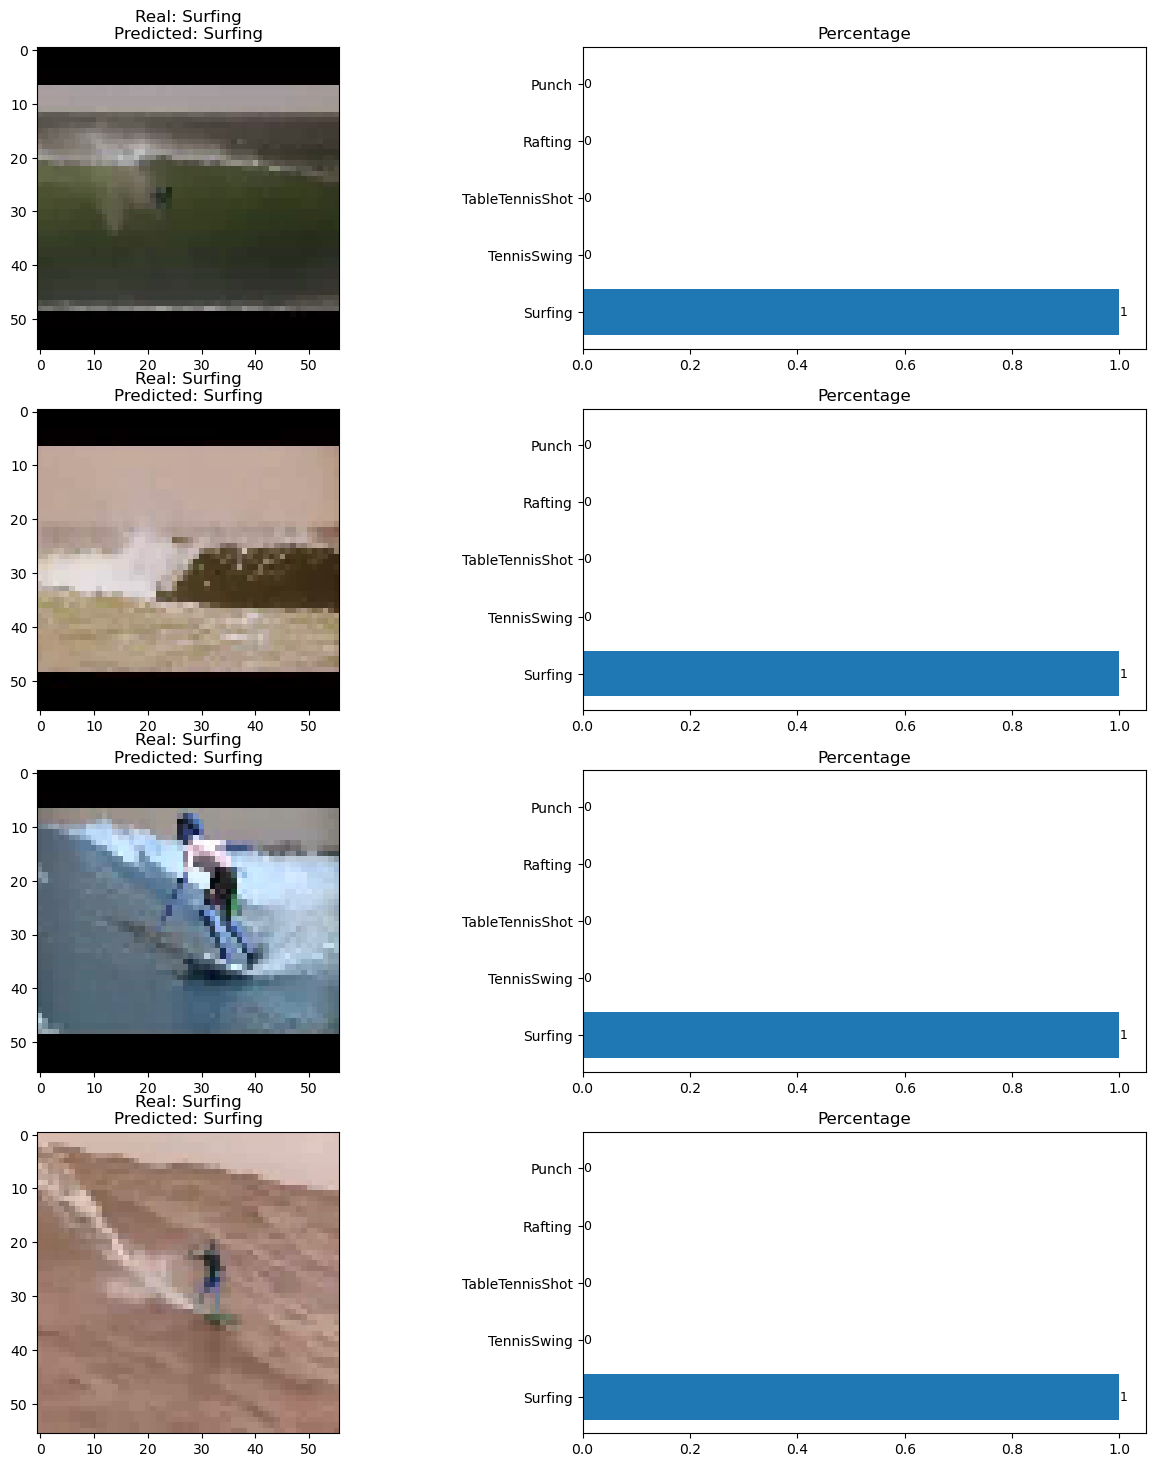

1/1 [==============================] - 0s 58ms/step


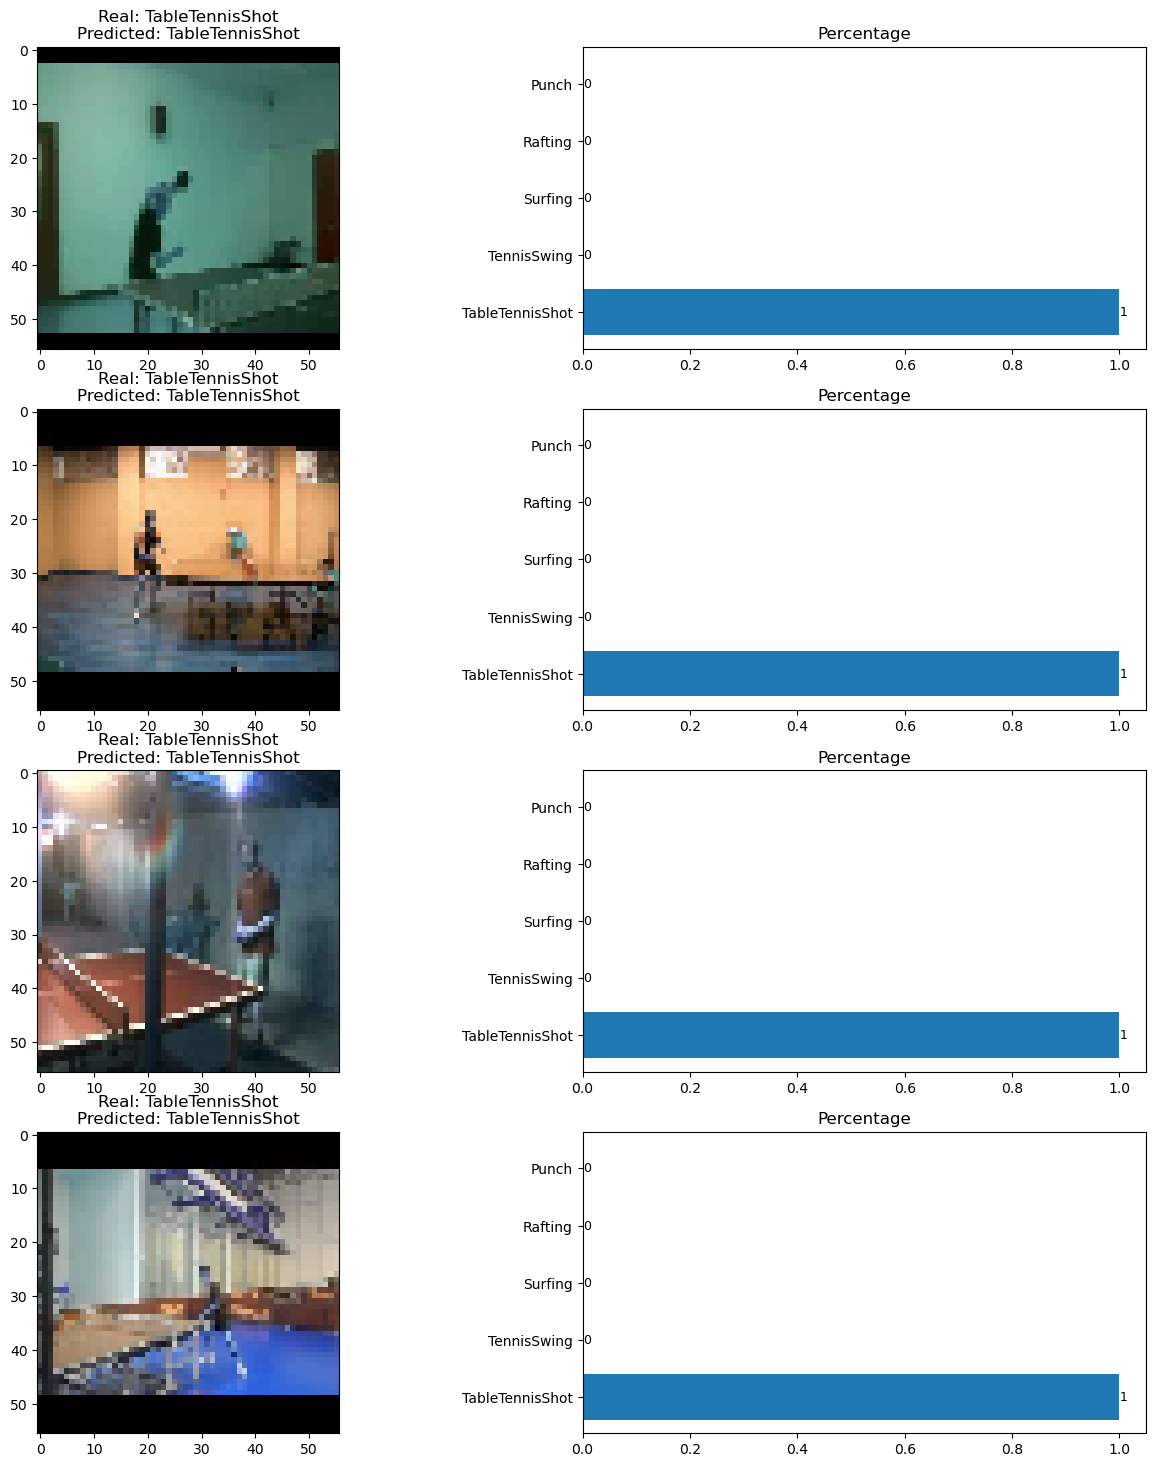

1/1 [==============================] - 0s 38ms/step


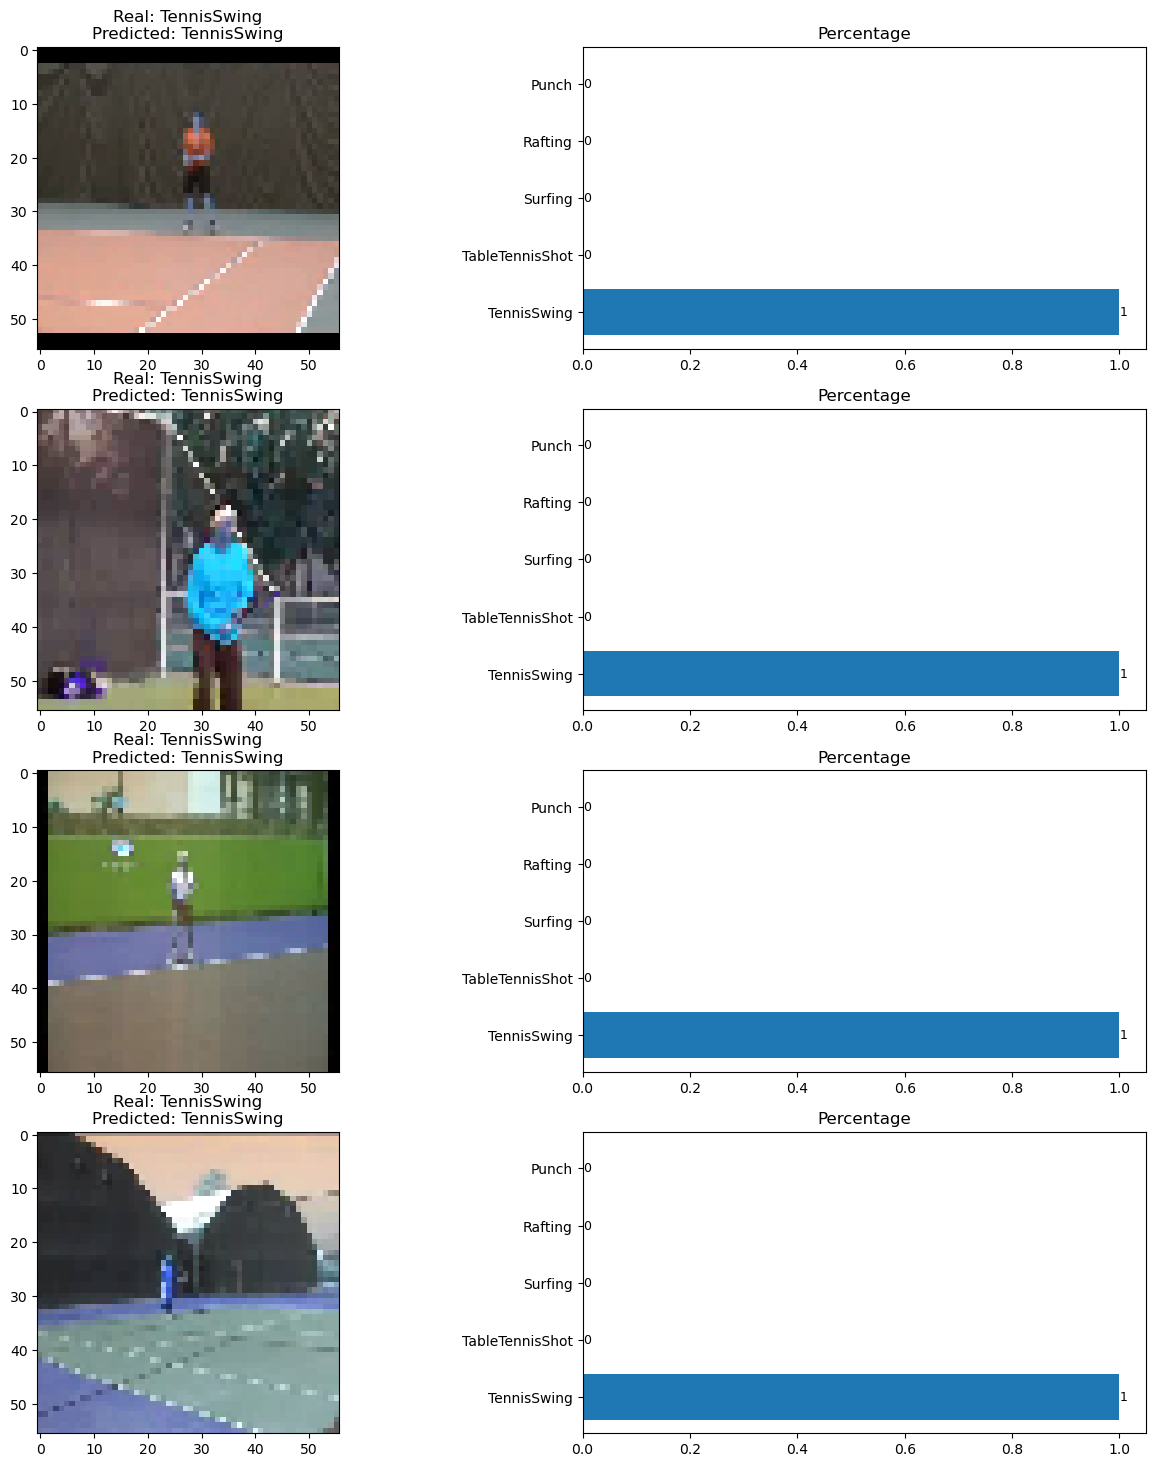

In [33]:
for i in range(5):
    arr = [0] * 5
    arr[i] = 1
    random_samples = np.random.choice(
        np.where((y_test_24 == tuple(arr)).all(axis=1))[0], 4, replace=False)
    k = 1
    plt.figure(figsize=(16, 18))
    for j in range(4):
        plt.subplot(4, 2, k)
        y_prediction_sample = best_cnn_model.predict(
            np.expand_dims(X_test_24[random_samples[j]], axis=0))
        y_prediction_sample_index = np.argmax(y_prediction_sample, axis=1)
        temp_img = np.round(X_test_24[random_samples[j]][0] * 255.0)
        temp_img = temp_img.astype(int)    
        plt.imshow(temp_img)
        plt.title("Real: " + categories[i] + "\nPredicted: " +
                categories[y_prediction_sample_index[0]])
        k += 1
        y_prediction_sample = np.round(y_prediction_sample, 2)
        maxN = y_prediction_sample[0].argsort()[-5:][::-1]
        plt.subplot(4, 2, k)
        bars = plt.barh(np.asarray(categories)[
                        maxN], y_prediction_sample[0][maxN])
        plt.bar_label(bars, fontsize=9)
        plt.title('Percentage')

        k += 1
    plt.show()

1/1 [==============================] - 0s 69ms/step


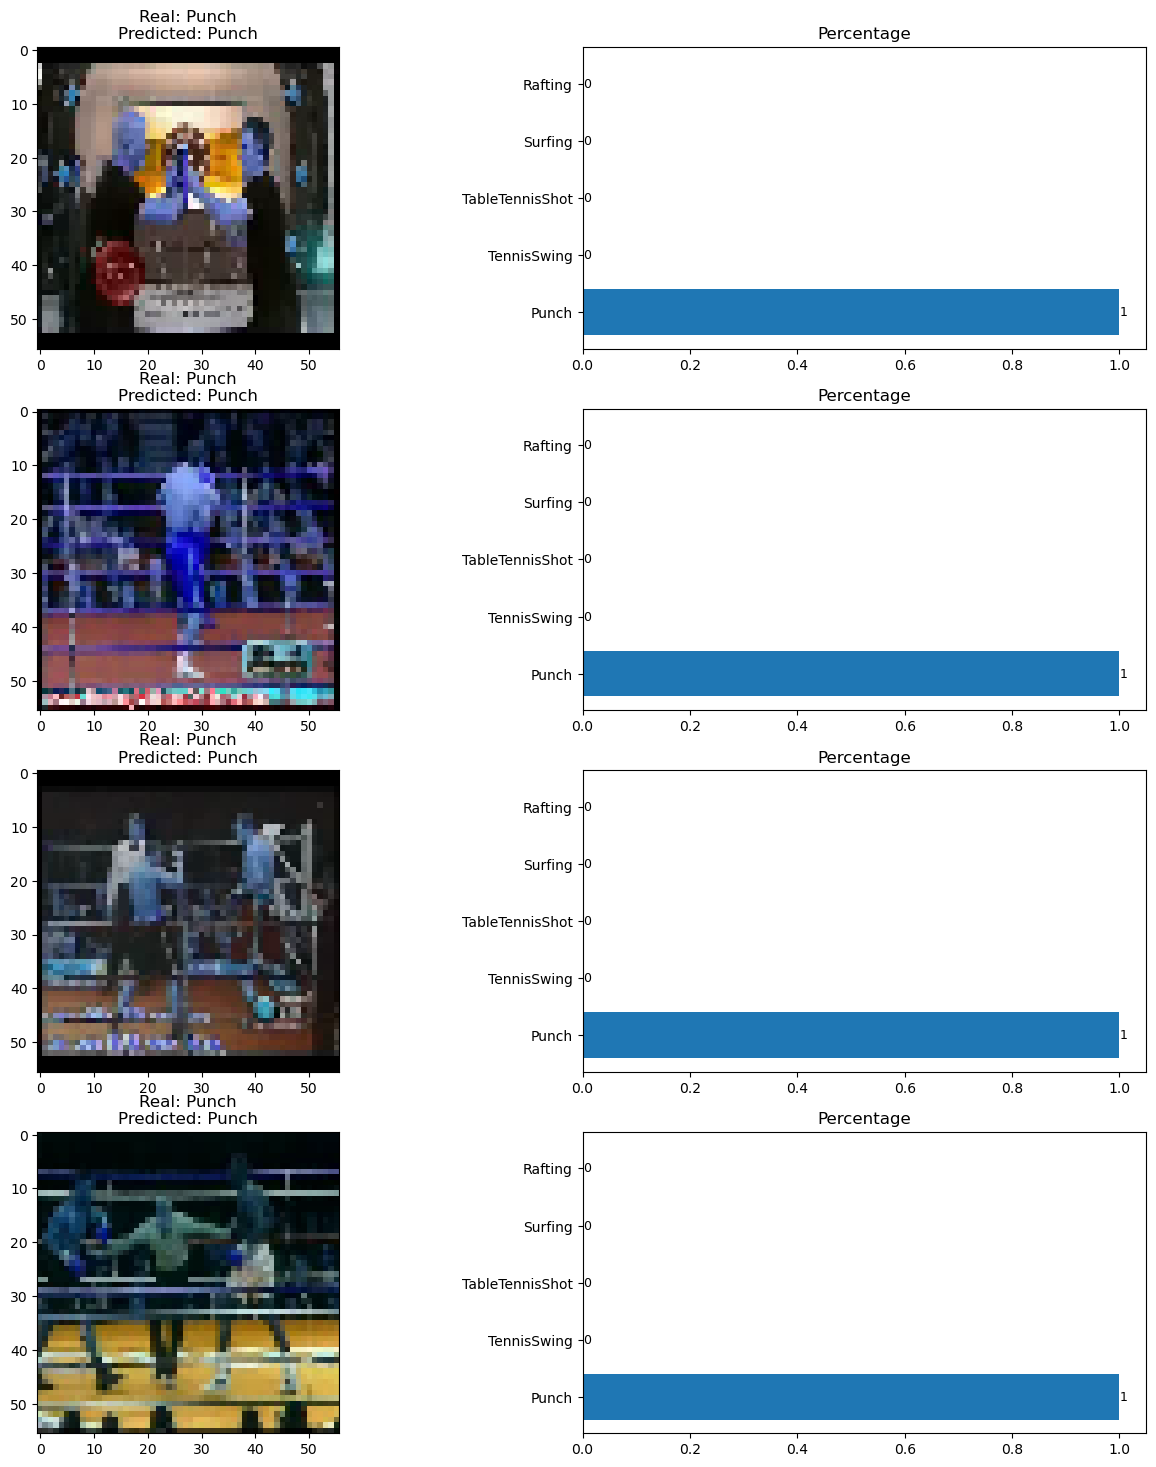

1/1 [==============================] - 0s 42ms/step


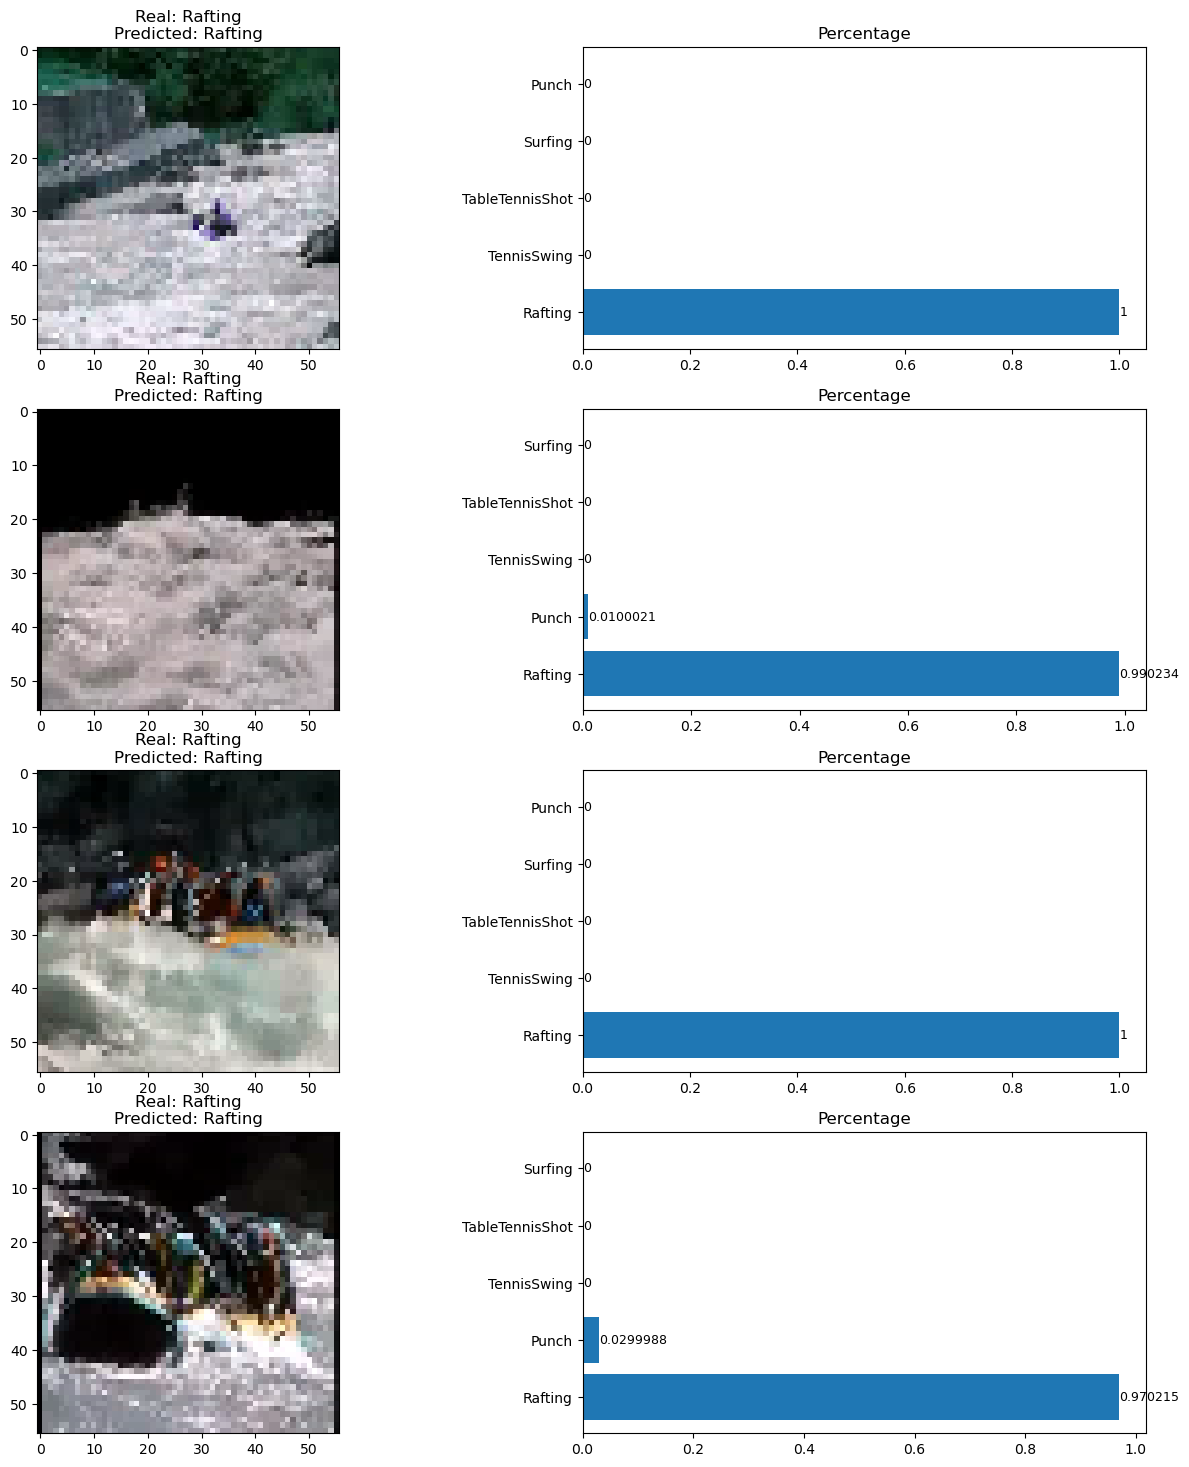

1/1 [==============================] - 0s 39ms/step


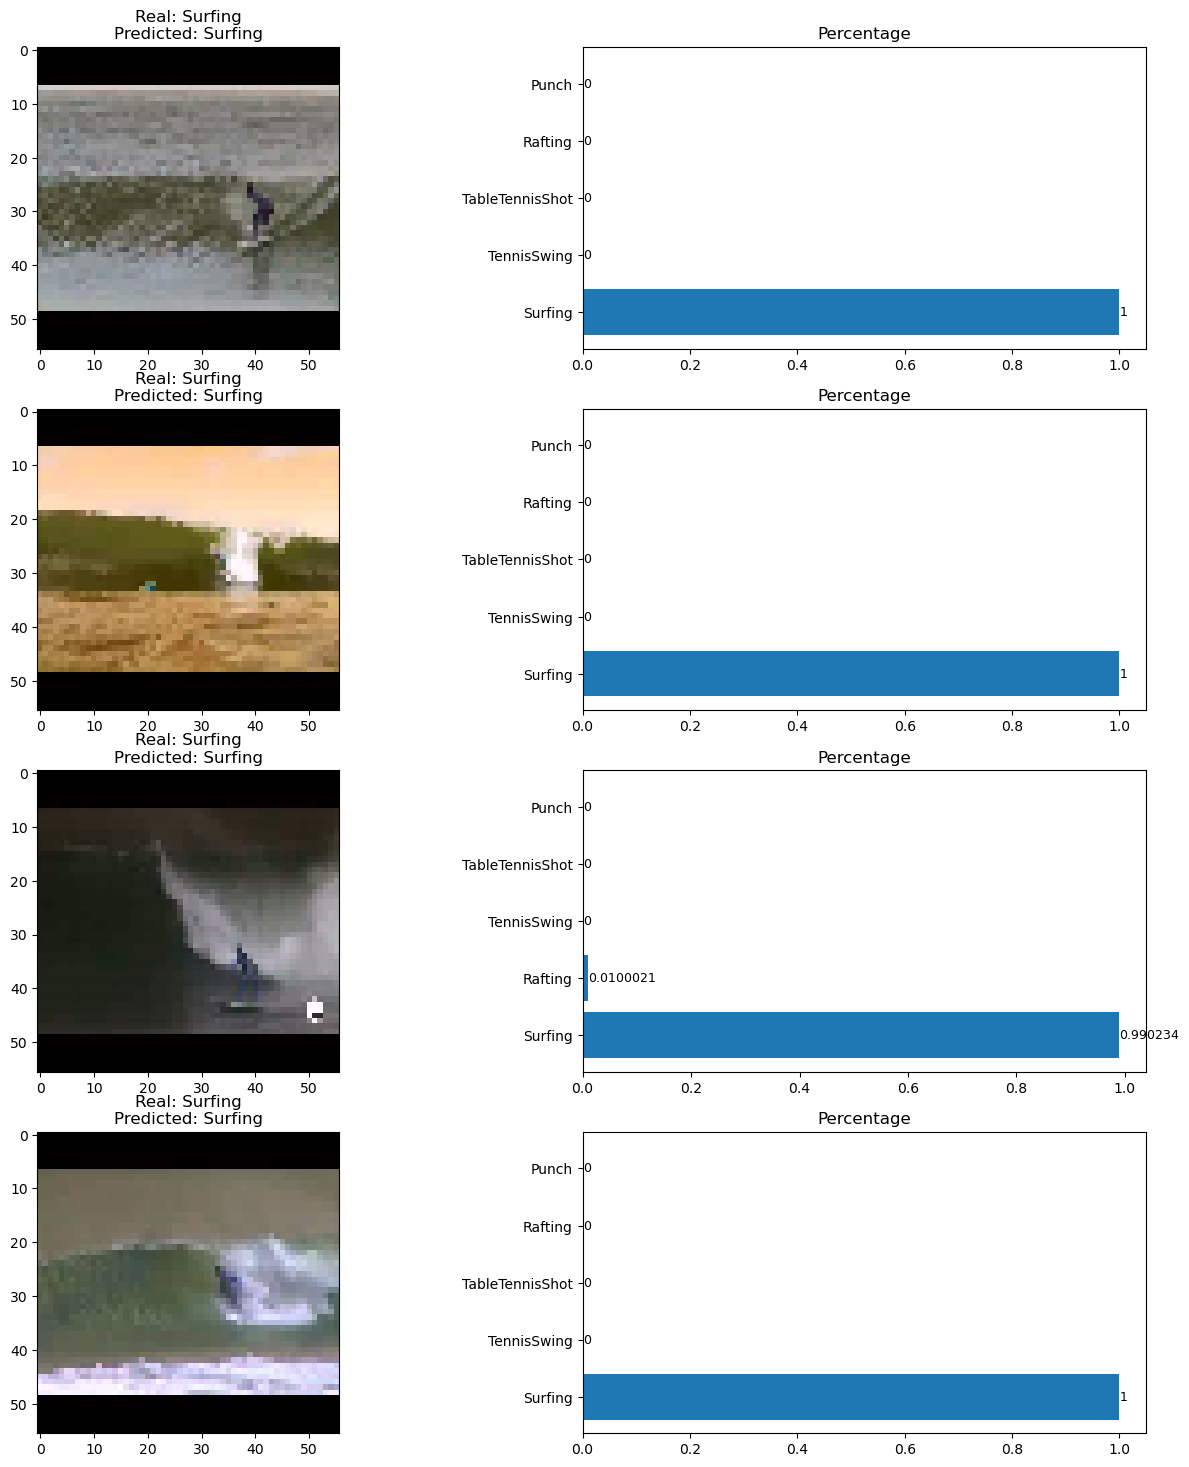

1/1 [==============================] - 0s 119ms/step


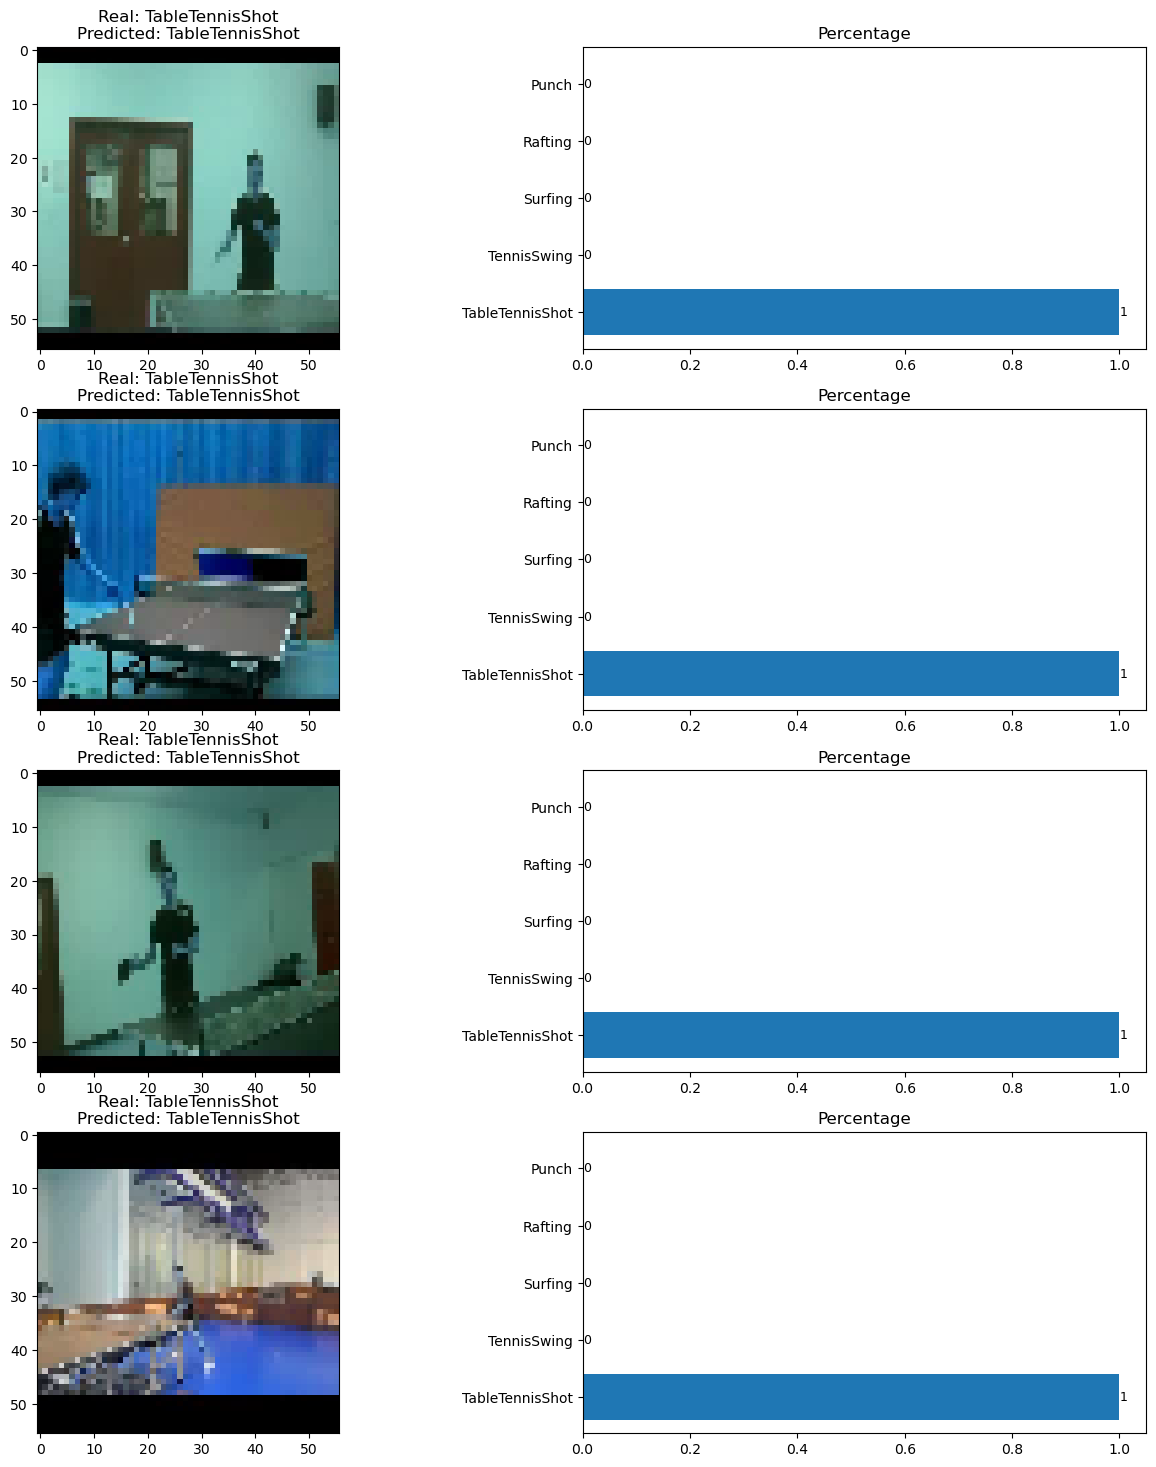

1/1 [==============================] - 0s 85ms/step


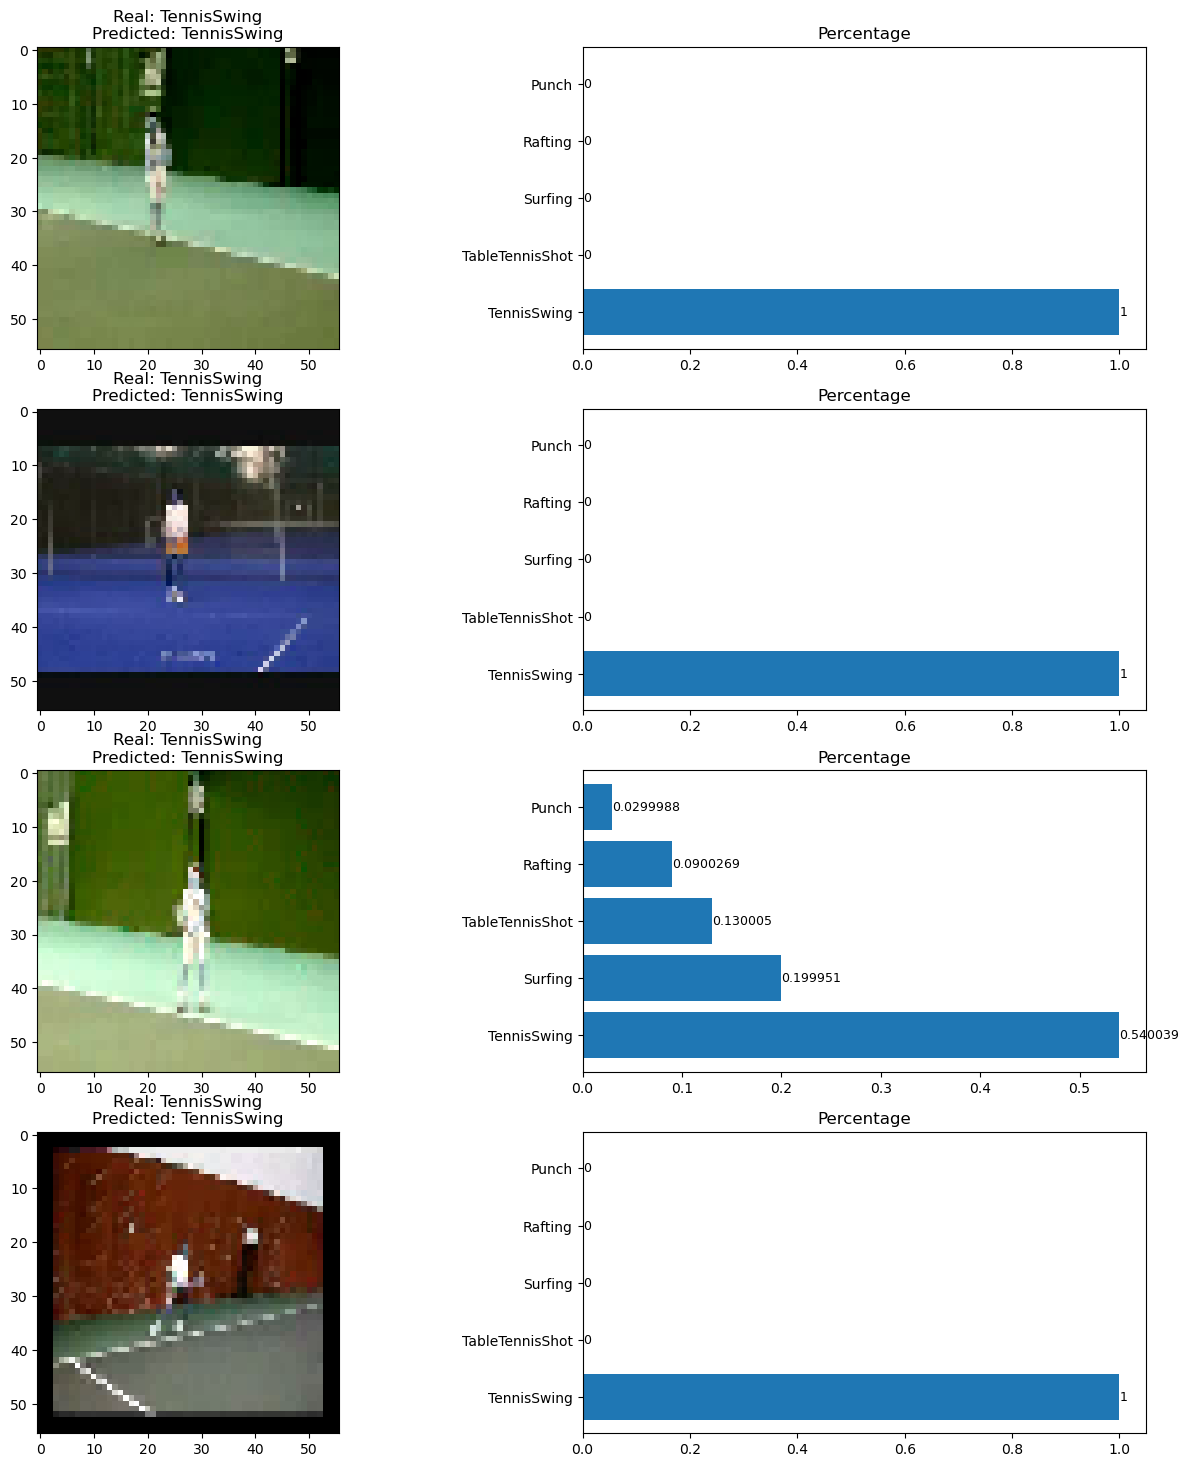

In [34]:
for i in range(5):
    arr = [0] * 5
    arr[i] = 1
    random_samples = np.random.choice(
        np.where((y_test_24 == tuple(arr)).all(axis=1))[0], 4, replace=False)
    k = 1
    plt.figure(figsize=(16, 18))
    for j in range(4):
        plt.subplot(4, 2, k)
        y_prediction_sample = best_lstm_model.predict(
            np.expand_dims(X_test_24[random_samples[j]], axis=0))
        y_prediction_sample_index = np.argmax(y_prediction_sample, axis=1)
        temp_img = np.round(X_test_24[random_samples[j]][0] * 255.0)
        temp_img = temp_img.astype(int)    
        plt.imshow(temp_img)
        plt.title("Real: " + categories[i] + "\nPredicted: " +
                categories[y_prediction_sample_index[0]])
        k += 1
        y_prediction_sample = np.round(y_prediction_sample, 2)
        maxN = y_prediction_sample[0].argsort()[-5:][::-1]
        plt.subplot(4, 2, k)
        bars = plt.barh(np.asarray(categories)[
                        maxN], y_prediction_sample[0][maxN])
        plt.bar_label(bars, fontsize=9)
        plt.title('Percentage')

        k += 1
    plt.show()